In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime

from datetime import timedelta, date
import time
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))

import sys
sys.path.append(code_dir)

from mechafil.data import get_historical_network_stats, get_sector_expiration_stats
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df
from mechafil.supply import forecast_circulating_supply_df

## 1. Parameters and other variables

In [3]:
# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# Today is 2022-11-01
current_date = datetime.date(2022, 11, 1) 
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 15)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast is one year ahead from today
forecast_lenght = 365
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2021-03-15
2022-11-01
2023-11-01


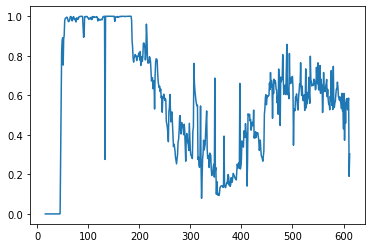

In [4]:
df_renewal_rate_orig = pd.read_csv('../offline_info/Scheduled_Expiration_by_Date_Breakdown_in_FIL.csv', 
                                   parse_dates=['stateTime'])
df_renewal_rate = df_renewal_rate_orig.copy()
df_renewal_rate = df_renewal_rate[df_renewal_rate.stateTime <= str(current_date)]
df_renewal_rate = df_renewal_rate[df_renewal_rate.stateTime >= str(start_date)]

df_renewal_rate['Renewal_Rate'] = df_renewal_rate['Extend'] / (df_renewal_rate['Extend'] 
                             + df_renewal_rate['Expired']
                             + df_renewal_rate['Potential Expire'] 
                             + df_renewal_rate['Terminate'])
df_renewal_rate.Renewal_Rate.plot();

In [5]:
end_day - start_day
historical_renewal_rate = df_renewal_rate.Renewal_Rate.values
future_renewal_rate_val = df_renewal_rate.Renewal_Rate.values[-1]
# future_renewal_rate_val = 1 # 0. Test extreme values for intuition
future_renewal_rate = np.repeat(future_renewal_rate_val, 
                                (end_day - start_day) - len(historical_renewal_rate))

In [6]:
# Renewal rate must now be a vector the length of the simulation
renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])
rb_onboard_power = 12.0
fil_plus_rate = 0.098

duration = 360

## 2. Input data

#### Sector scheduled expirations

In [7]:
res = get_sector_expiration_stats(start_date, current_date,end_date)

rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]
known_scheduled_pledge_release_full_vec = res[2]

#### Daily network stats

In [8]:
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
current_day_stats

circulating_fil               384714480.309213
mined_fil                     233855840.958391
vested_fil                    301765965.131562
locked_fil                    134508108.842877
burnt_fil                      33465835.899636
date                                2022-11-01
total_raw_power_eib                  16.017958
total_qa_power_eib                    18.62947
day_onboarded_rb_power_pib            9.735138
day_onboarded_qa_power_pib           25.884187
day_renewed_qa_power_pib            117.858355
Name: 595, dtype: object

In [9]:
fil_stats_df.head()

,circulating_fil,mined_fil,vested_fil,locked_fil,burnt_fil,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_rb_power_pib,day_onboarded_qa_power_pib,day_renewed_qa_power_pib
0,1.011143e+08,4.294468e+07,1.093991e+08,4.913035e+07,1.916571e+07,2021-03-16,3.310809,3.311754,31.176788,30.780540,0.0
1,1.016796e+08,4.329793e+07,1.100472e+08,4.953880e+07,1.919340e+07,2021-03-17,3.341048,3.341986,32.155762,31.852937,0.0
2,1.022119e+08,4.364709e+07,1.106954e+08,4.994090e+07,1.925624e+07,2021-03-18,3.369592,3.370540,31.870209,31.465290,0.0
3,1.027568e+08,4.399606e+07,1.113435e+08,5.034152e+07,1.930788e+07,2021-03-19,3.396884,3.397818,31.849304,31.453568,0.0
4,1.033046e+08,4.435056e+07,1.119917e+08,5.075548e+07,1.934878e+07,2021-03-20,3.430672,3.431702,32.787598,32.455248,0.0


## 2. Forecast power stats

In [10]:
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

rb_power_df, qa_power_df = forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rb_onboard_power,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    renewal_rate_vec,
    fil_plus_rate,
    duration,
    forecast_lenght
)
rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

In [11]:
power_df = build_full_power_stats_df(
    fil_stats_df,
    rb_power_df,
    qa_power_df,
    start_date,
    current_date,
    end_date,
)

print(len(power_df))
power_df.head()

961


,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_qa_power_pib,day_renewed_qa_power_pib
0,2021-03-15,3.310809,3.311754,30.780540,0.0
1,2021-03-16,3.310809,3.311754,30.780540,0.0
2,2021-03-17,3.341048,3.341986,31.852937,0.0
3,2021-03-18,3.369592,3.370540,31.465290,0.0
4,2021-03-19,3.396884,3.397818,31.453568,0.0


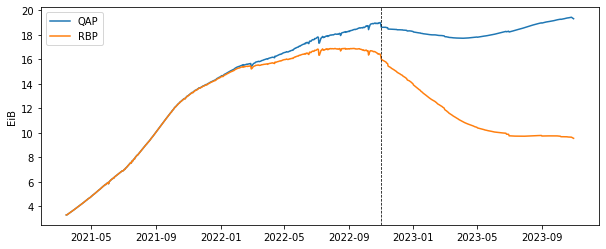

In [12]:
plt.figure(figsize=(10,4))
plt.plot(power_df['date'], power_df['total_qa_power_eib'], label="QAP")
plt.plot(power_df['date'], power_df['total_raw_power_eib'], label="RBP")
plt.axvline(power_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.ylabel("EiB")
plt.legend()
plt.show()

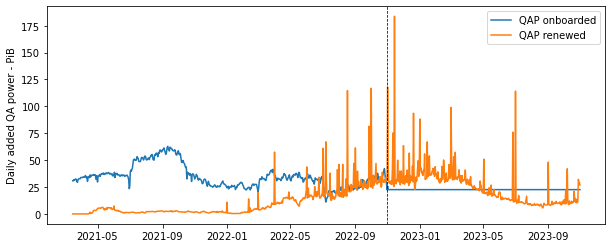

In [13]:
plt.figure(figsize=(10,4))
plt.plot(power_df['date'], power_df['day_onboarded_qa_power_pib'], label="QAP onboarded")
plt.plot(power_df['date'], power_df['day_renewed_qa_power_pib'], label="QAP renewed")
plt.axvline(power_df['date'][current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.ylabel("Daily added QA power - PiB")
plt.legend()
plt.show()

## 3. Forecast minting stats and baseline

In [14]:
rb_total_power_eib = power_df["total_raw_power_eib"].values
qa_total_power_eib = power_df["total_qa_power_eib"].values
qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

mint_df = compute_minting_trajectory_df(
    start_date,
    end_date,
    rb_total_power_eib,
    qa_total_power_eib,
    qa_day_onboarded_power_pib,
    qa_day_renewed_power_pib,
)

#### check network time

In [16]:
# if need to pull data to check network time
# from sqlalchemy import create_engine

# CONFIG_STRING_PATH = '../../../Data/Sentinel/config/sentinel_config.txt'
# with open(CONFIG_STRING_PATH, 'r') as fid:
#     conn_string = fid.read()
#     engine = create_engine(conn_string)
    
# model_ = 'chain_rewards'
# QUERY = f"""
# SELECT 
# to_timestamp(height_to_unix(height)) AS timestamp, cum_sum_baseline, cum_sum_realized, effective_baseline_power, new_baseline_power, total_mined_reward, effective_network_time 
# FROM visor.{model_}
# """
# pd.read_sql(QUERY, engine).to_csv(f'../../../Data/Sentinel/{model_}.csv')
# df_rewards_orig = pd.read_csv(f'../../../Data/Sentinel/{model_}.csv')

# rewards_df = df_rewards_orig.copy()
# rewards_df = rewards_df.sort_values("timestamp").reset_index()
# rewards_df['date'] = pd.to_datetime(rewards_df.timestamp, format='%Y-%m-%d')
# rewards_df = rewards_df.groupby(rewards_df.date.dt.date).mean() # daily so lighter weight
# rewards_df.index = pd.to_datetime(rewards_df.index, format='%Y-%m-%d')
# rewards_df.to_csv('../offline_info/chain_rewards.csv')

In [17]:
rewards_df = pd.read_csv('../offline_info/chain_rewards.csv', parse_dates=['date'])
rewards_df = rewards_df[rewards_df.date >= str(start_date)]
rewards_df.index = rewards_df.date

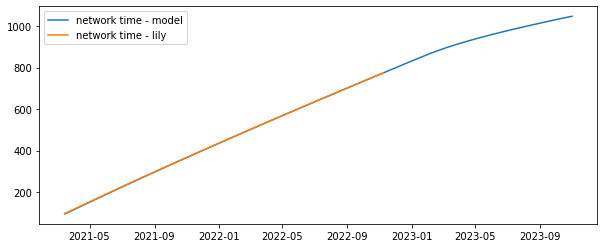

In [18]:
plt.figure(figsize=(10,4))
plt.plot(mint_df["date"], mint_df['network_time'], label="network time - model")
plt.plot(rewards_df.date, rewards_df["effective_network_time"]/(60*24*2), label="network time - lily");
plt.legend()
plt.show()

#### check baseline crossing

-0.011248769182221618

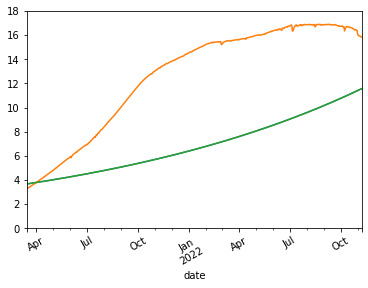

In [19]:
# BASELINE_B0 = 2.88888888 # should be this
BASELINE_B0 = 2.7636 # this value is required to match sentinel
BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
EPOCH_PER_DAY = 2880
def baseline_storage(epoch: float)->float:
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

rewards_df.new_baseline_power.pipe(lambda x : x / (2**60)).plot()
plt.plot(power_df.date, power_df.total_raw_power_eib)
plt.plot(mint_df.date, baseline_storage(mint_df.days * EPOCH_PER_DAY))
plt.xticks(rotation=30);
plt.ylim(0,18)

np.sum(rewards_df.new_baseline_power.pipe(lambda x : x / (2**60)).values[:500]-baseline_storage(mint_df.days * EPOCH_PER_DAY).values[:500])

#### check minting

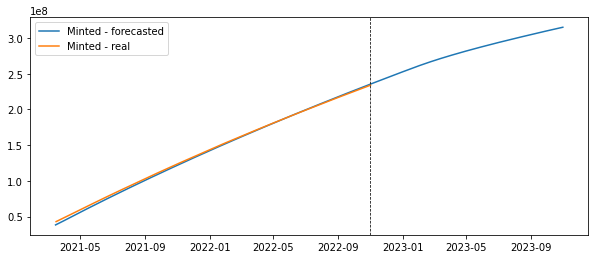

In [20]:
plt.figure(figsize=(10,4))
plt.plot(mint_df["date"], mint_df['cum_network_reward'], label="Minted - forecasted")
plt.plot(fil_stats_df["date"], fil_stats_df['mined_fil'],label="Minted - real")
plt.axvline(mint_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

Build Counterfactual Power Scenario

In [38]:
baseline_crossing = mint_df['date'].iloc[current_day-start_day-1]

f = lambda df: baseline_storage(df.days * EPOCH_PER_DAY)

def generate_baseline_RBP(df: pd.DataFrame,
                          baseline_crossing=baseline_crossing) -> pd.Series:
    after_crossing_indices = df.date > baseline_crossing
    counterfactual_RBP = df.network_RBP.copy()
    counterfactual_RBP[after_crossing_indices] = df.baseline
    return counterfactual_RBP

def generate_baseline_QAP(df: pd.DataFrame,
                          future_qap = 2) -> pd.Series:
    return df.network_RBP * future_qap

counterfactual_df = (mint_df.copy()
                            .assign(baseline=f)
                            .assign(network_RBP=generate_baseline_RBP)
                            .assign(network_QAP=generate_baseline_QAP)
                    )

In [39]:
counterfactual_df

,days,date,network_RBP,network_QAP,day_onboarded_power_QAP,day_renewed_power_QAP,cum_simple_reward,network_baseline,capped_power,cum_capped_power,network_time,cum_baseline_reward,cum_network_reward,day_network_reward,baseline
0,151,2021-03-15,3.817103e+18,7.634206e+18,3.465581e+16,0.000000e+00,1.540053e+07,4.248358e+18,3.817103e+18,3.023795e+20,95.468178,2.291848e+07,3.831901e+07,359863.935912,3.681382
1,152,2021-03-16,3.817103e+18,7.634206e+18,3.465581e+16,0.000000e+00,1.550008e+07,4.256434e+18,3.817103e+18,3.061966e+20,96.569241,2.317879e+07,3.867887e+07,359863.935912,3.688380
2,153,2021-03-17,3.851966e+18,7.703932e+18,3.586322e+16,0.000000e+00,1.559961e+07,4.264525e+18,3.851966e+18,3.100485e+20,97.678033,2.344083e+07,3.904044e+07,361567.650078,3.695391
3,154,2021-03-18,3.884875e+18,7.769750e+18,3.542677e+16,0.000000e+00,1.569910e+07,4.272631e+18,3.884875e+18,3.139334e+20,98.793937,2.370446e+07,3.940357e+07,363124.361359,3.702415
4,155,2021-03-19,3.916341e+18,7.832682e+18,3.541357e+16,0.000000e+00,1.579857e+07,4.280752e+18,3.916341e+18,3.178497e+20,99.916492,2.396957e+07,3.976814e+07,364569.989367,3.709453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,1107,2023-10-27,2.261841e+01,4.523682e+01,2.542732e+16,1.290411e+16,9.753934e+07,2.610191e+19,1.112857e+19,9.537594e+21,1044.585507,2.167702e+08,3.143096e+08,166427.602232,22.618409
957,1108,2023-10-28,2.266140e+01,4.532281e+01,2.542732e+16,3.618166e+16,9.761291e+07,2.615153e+19,1.109807e+19,9.548692e+21,1045.113694,2.168627e+08,3.144756e+08,166041.423284,22.661403
958,1109,2023-10-29,2.270448e+01,4.540896e+01,2.542732e+16,3.296040e+16,9.768645e+07,2.620124e+19,1.107150e+19,9.559763e+21,1045.640089,2.169549e+08,3.146413e+08,165688.968376,22.704478
959,1110,2023-10-30,2.274764e+01,4.549527e+01,2.542732e+16,3.271358e+16,9.775996e+07,2.625104e+19,1.104522e+19,9.570808e+21,1046.164710,2.170467e+08,3.148067e+08,165340.021695,22.747636


## 4. Forecast Vesting

In [ ]:
vest_df = compute_vesting_trajectory_df(start_date, end_date)

print(len(vest_df))
vest_df.head()

plt.figure(figsize=(10,4))
plt.plot(vest_df["date"], vest_df['total_vest'], label="Vested - forecasted")
plt.plot(fil_stats_df["date"], fil_stats_df['vested_fil'],label="Vested - real")
plt.axvline(vest_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

## 5. Compute circulating supply

In [ ]:
start_day_stats = fil_stats_df.iloc[0]
circ_supply_zero = start_day_stats["circulating_fil"]
locked_fil_zero = start_day_stats["locked_fil"]
burnt_fil_zero = start_day_stats["burnt_fil"]
daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
burnt_fil_vec = fil_stats_df["burnt_fil"].values

cil_df = forecast_circulating_supply_df(
    start_date,
    current_date,
    end_date,
    circ_supply_zero,
    locked_fil_zero,
    daily_burnt_fil,
    duration,
    renewal_rate_vec,
    burnt_fil_vec,
    vest_df,
    mint_df,
    known_scheduled_pledge_release_full_vec
)
MEGA = 10 ** 6
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['locked_fil'] / MEGA,label="Locked - real")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['cum_network_reward'] / MEGA,label='Mined FIL')
plt.plot(cil_df['date'], cil_df['circ_supply'] / MEGA,label="Circulating Supply")
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked")
plt.plot(cil_df['date'], cil_df['network_gas_burn'] / MEGA,label="Gas Burnt")
plt.plot(cil_df['date'], cil_df['total_vest'] / MEGA,label="Total vest")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.xticks(rotation=30)
plt.ylabel("M-FIL")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['cum_network_reward'] / MEGA,label='Mined FIL')
plt.plot(cil_df['date'], cil_df['circ_supply'] / MEGA,label="Circulating Supply")
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked")
plt.plot(cil_df['date'], cil_df['network_gas_burn'] / MEGA,label="Gas Burnt")
plt.plot(cil_df['date'], cil_df['total_vest'] / MEGA,label="Total vest")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.xticks(rotation=30)
plt.ylabel("M-FIL")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['network_gas_burn'] / MEGA,label="network_gas_burn - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['burnt_fil'] / MEGA,label="burnt_fil - real")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['circ_supply'] / MEGA,label="Circulating Supply - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['circulating_fil'] / MEGA,label="Circulating Supply - real")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(cil_df['date'], cil_df['network_locked'] / MEGA,label="Locked - forecasted")
plt.plot(fil_stats_df['date'], fil_stats_df['locked_fil'] / MEGA,label="Locked - real")
plt.axvline(cil_df['date'].iloc[current_day-start_day-1], color='black', linestyle='--', lw=0.75)
plt.legend()
plt.show()